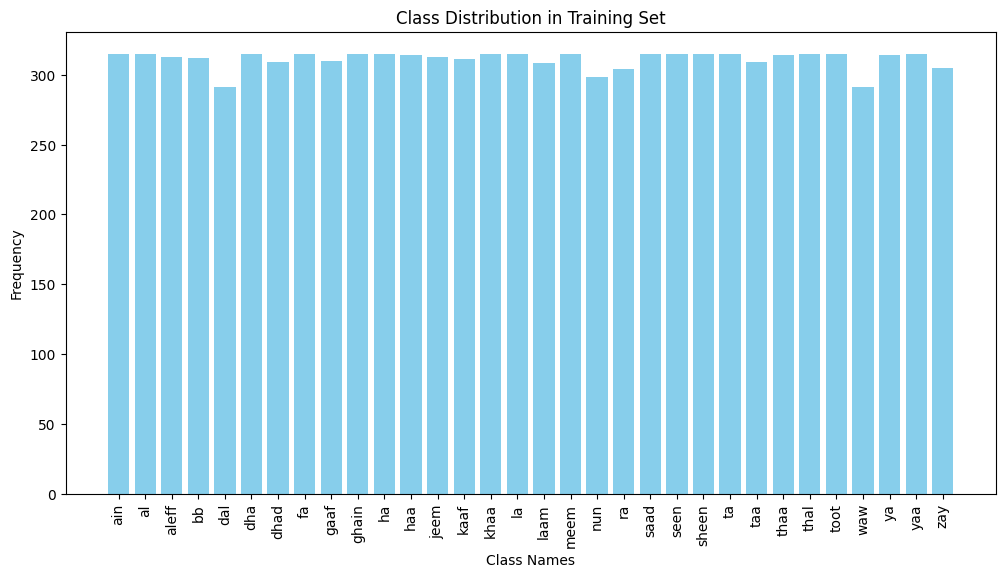

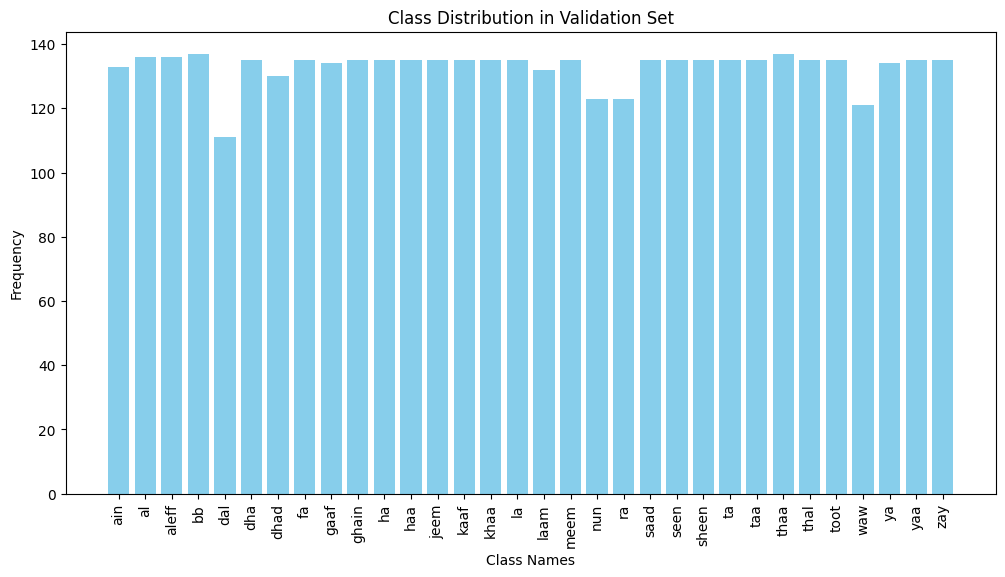

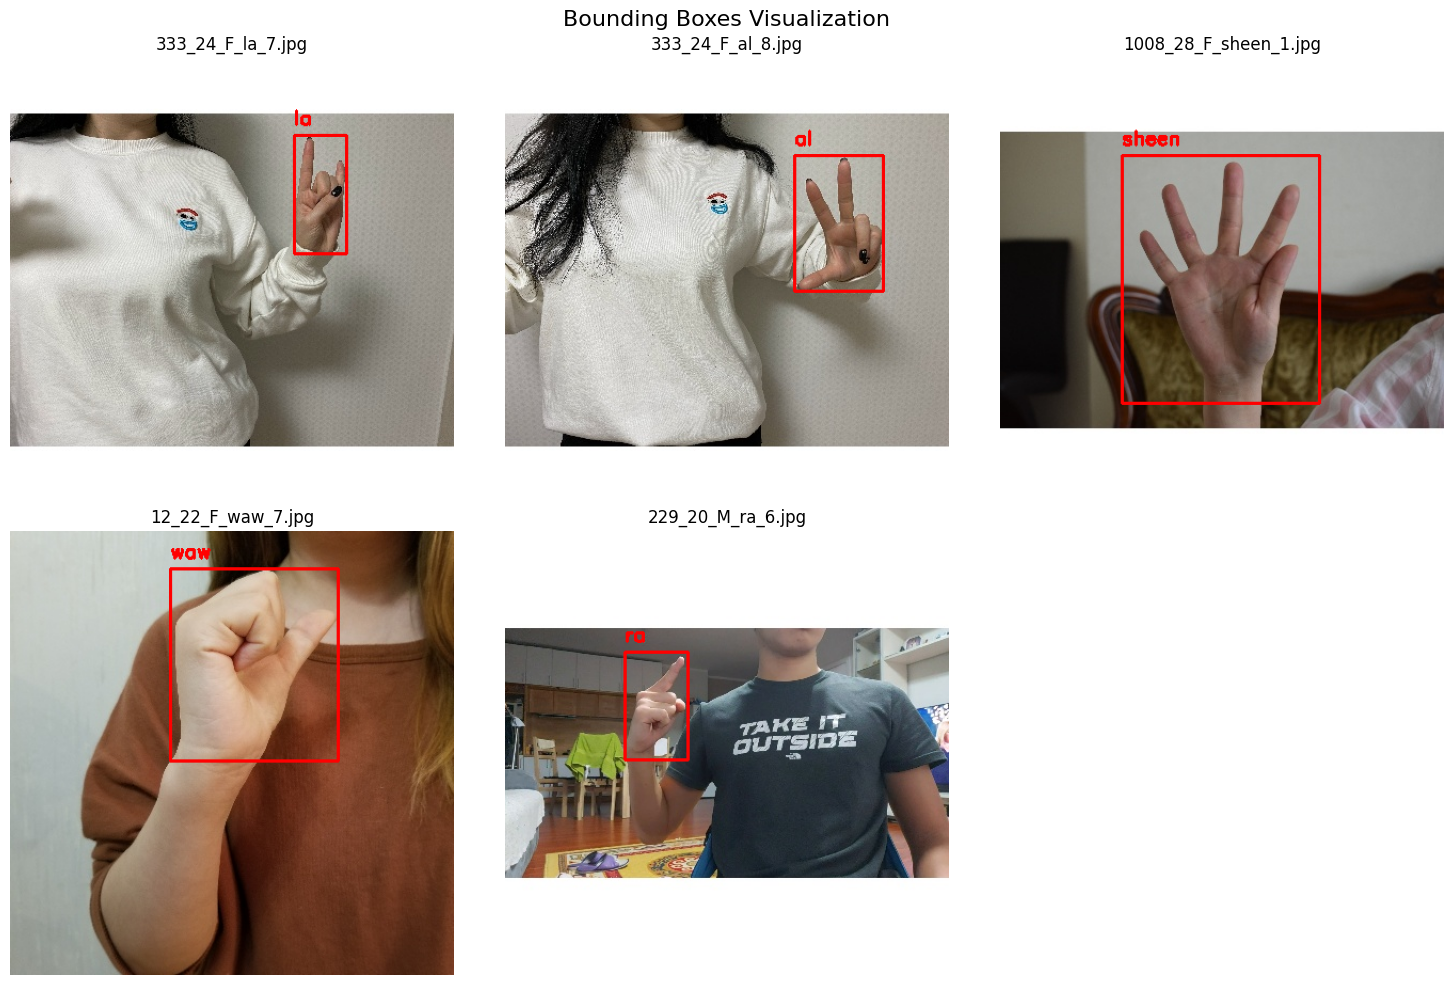

In [2]:
import os
import matplotlib.pyplot as plt
from glob import glob
import cv2
import numpy as np
from PIL import Image

# Paths to images and labels
train_images_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/train/images"
train_labels_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/train/labels"
valid_images_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/valid/images"
valid_labels_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/valid/labels"

# Class names
class_names = [
    'ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain',
    'ha', 'haa', 'jeem', 'kaaf', 'khaa', 'la', 'laam', 'meem', 'nun', 'ra',
    'saad', 'seen', 'sheen', 'ta', 'taa', 'thaa', 'thal', 'toot', 'waw', 'ya', 'yaa', 'zay'
]

# Function to parse labels
def parse_labels(label_path):
    class_ids = []
    label_files = glob(f"{label_path}/*.txt")
    for file in label_files:
        with open(file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                class_id = int(line.split()[0])  # Extract the class ID
                class_ids.append(class_id)
    return class_ids

# Extract class IDs from training and validation labels
train_class_ids = parse_labels(train_labels_path)
valid_class_ids = parse_labels(valid_labels_path)

# Plot class distributions
def plot_class_distribution(class_ids, title):
    unique, counts = np.unique(class_ids, return_counts=True)
    plt.figure(figsize=(12, 6))
    plt.bar([class_names[i] for i in unique], counts, color='skyblue')
    plt.xticks(rotation=90)
    plt.xlabel("Class Names")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

# Visualize class distributions
plot_class_distribution(train_class_ids, "Class Distribution in Training Set")
plot_class_distribution(valid_class_ids, "Class Distribution in Validation Set")

# Function to visualize bounding boxes
def visualize_bounding_boxes(image_path, label_path):
    image_files = glob(f"{image_path}/*.jpg")[:5]  # Visualize first 5 images
    plt.figure(figsize=(15, 10))
    
    for idx, img_file in enumerate(image_files):
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        
        # Load corresponding label file
        label_file = os.path.join(label_path, os.path.basename(img_file).replace(".jpg", ".txt"))
        with open(label_file, 'r') as f:
            labels = f.readlines()
        
        # Draw bounding boxes
        for label in labels:
            class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
            x_center, y_center = int(x_center * width), int(y_center * height)
            bbox_width, bbox_height = int(bbox_width * width), int(bbox_height * height)
            x1, y1 = int(x_center - bbox_width / 2), int(y_center - bbox_height / 2)
            x2, y2 = int(x_center + bbox_width / 2), int(y_center + bbox_height / 2)
            
            # Draw rectangle and class name
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, class_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        
        # Plot image
        plt.subplot(2, 3, idx + 1)
        plt.imshow(img)
        plt.title(os.path.basename(img_file))
        plt.axis('off')

    plt.suptitle("Bounding Boxes Visualization", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize bounding boxes for training data
visualize_bounding_boxes(train_images_path, train_labels_path)


In [2]:
import torch
import torch.nn as nn
from torchvision import models

# Number of classes
num_classes = 32

# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ==============================
# 1. ResNet-Based Model
# ==============================
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        # Load pretrained ResNet-18 model
        self.resnet = models.resnet18(pretrained=True)
        # Replace the final fully connected layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Instantiate ResNet model
resnet_model = ResNetClassifier(num_classes=num_classes).to(device)

# Print ResNet model summary
print("ResNet Model Summary:")
print(resnet_model)
resnet_params = sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {resnet_params:,}\n")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s] 


ResNet Model Summary:
ResNetClassifier(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, moment

In [75]:
class HandCraftedCNN(nn.Module):
    def __init__(self, num_classes, input_size=(224, 224)):  # input_size is now (224, 224)
        super(HandCraftedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

        # Dynamically compute the flattened size after convolutional layers
        conv_output_size = self._get_conv_output_size(input_size)
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def _get_conv_output_size(self, input_size):
        # Perform a dummy forward pass to calculate the size of the flattened feature map
        with torch.no_grad():
            x = torch.zeros(1, 3, *input_size)  # Batch size = 1, 3 channels
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            return int(torch.flatten(x, 1).size(1))


# Instantiate Handcrafted CNN model
cnn_model = HandcraftedCNN(num_classes=num_classes).to(device)

# Print Handcrafted CNN model summary
print("Handcrafted CNN Model Summary:")
print(cnn_model)
cnn_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
print(f"Total Trainable Parameters: {cnn_params:,}")

Handcrafted CNN Model Summary:
HandcraftedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1, out_features=512, bias=True)
  (fc_layers): Sequ

In [35]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch
import glob  
import glob  # Import glob module
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import torch
import glob  
import glob  # Import glob module
import os
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np
class SignLanguageDataset(Dataset):
    def __init__(self, image_path, label_path, transform=None):
        self.image_files = glob.glob(f"{image_path}/*.jpg")
        self.label_path = label_path
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_file = self.image_files[idx]
        img = Image.open(img_file).convert("RGB")

        # Get image dimensions
        img = np.array(img)
        height, width, _ = img.shape

        # Load labels (class information only, no bounding boxes for classification)
        label_file = os.path.join(self.label_path, os.path.basename(img_file).replace(".jpg", ".txt"))
        with open(label_file, 'r') as f:
            labels = f.readlines()

        # Assuming there's only one label per image, extract class
        class_ids = []
        for label in labels:
            class_id = int(label.split()[0])  # class_id is the first value in the line
            class_ids.append(class_id)

        # Convert to a tensor of class IDs (we assume here that it's a single class per image)
        # If there are multiple classes per image, you would need a different approach.
        if len(class_ids) > 1:
            # You may decide how to handle multiple classes per image; for now, using the first class
            class_id = class_ids[0]
        else:
            class_id = class_ids[0]

        # Apply transformations if any
        if self.transform:
            img = self.transform(img)

        # Return only the image and the class label
        return img, torch.tensor(class_id, dtype=torch.long)

                    
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(classes, dtype=torch.long)  # Return only image and class label

                    
        # Apply transformations
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(classes, dtype=torch.long)  # Return only image and class label



# Define transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [36]:
train_images_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/train/images"
train_labels_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/train/labels"
valid_images_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/valid/images"
valid_labels_path = "/kaggle/input/arabic-sign-language-dataset-2022/datasets/valid/labels"

# Create datasets
train_dataset = SignLanguageDataset(train_images_path, train_labels_path, transform=train_transform)
valid_dataset = SignLanguageDataset(valid_images_path, valid_labels_path, transform=valid_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Check the dataset
sample_img, sample_classes = train_dataset[0]
print("Sample Image Shape:", sample_img.shape)
print("Sample Classes:", sample_classes)

# Iterate over train_loader to verify data loading
for images, classes in train_loader:  # Unpack only two values
    print("Batch Image Shape:", images.shape)
    print("Batch Classes Shape:", classes.shape)
    break

Sample Image Shape: torch.Size([3, 224, 224])
Sample Classes: tensor(15)
Batch Image Shape: torch.Size([32, 3, 224, 224])
Batch Classes Shape: torch.Size([32])


In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

# Optimizer and scheduler
def get_optimizer_scheduler(model):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR after 10 epochs
    return optimizer, scheduler


In [64]:
# History to store fold-specific metrics
fold_histories = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
    print(f"Fold {fold + 1}/{kfold.n_splits}")

    # Split data into training and validation
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler, num_workers=4)
    valid_loader = DataLoader(train_dataset, batch_size=32, sampler=val_subsampler, num_workers=4)

    # Initialize model, optimizer, and scheduler
    model = ResNetClassifier(num_classes=32).to(device)
    optimizer, scheduler = get_optimizer_scheduler(model)

    # Metrics for the current fold
    fold_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train_fold = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train_fold += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()

        # Calculate training accuracy and loss for the epoch
        train_accuracy = 100 * correct_train / total_train_fold
        train_loss = running_loss / len(train_loader)
        scheduler.step()

        # Validation
        model.eval()
        correct_val = 0
        total_val_fold = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val_fold += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation accuracy and loss
        val_accuracy = 100 * correct_val / total_val_fold
        val_loss /= len(valid_loader)

        # Print metrics for the current epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Accuracy: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}")

        # Append metrics for the current epoch to fold history
        fold_history['train_loss'].append(train_loss)
        fold_history['val_loss'].append(val_loss)
        fold_history['train_acc'].append(train_accuracy)
        fold_history['val_acc'].append(val_accuracy)

    # Save fold-specific history
    fold_histories.append(fold_history)

  

# Aggregate metrics across folds
def aggregate_folds(fold_histories):
    num_folds = len(fold_histories)
    num_epochs = len(fold_histories[0]['train_loss'])
    aggregated_history = {
        "train_loss": np.mean([fold['train_loss'] for fold in fold_histories], axis=0),
        "val_loss": np.mean([fold['val_loss'] for fold in fold_histories], axis=0),
        "train_acc": np.mean([fold['train_acc'] for fold in fold_histories], axis=0),
        "val_acc": np.mean([fold['val_acc'] for fold in fold_histories], axis=0)
    }
    return aggregated_history

aggregated_history = aggregate_folds(fold_histories)

# Plot performance
def plot_performance(history, title):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_performance(aggregated_history, "ResNet Model Performance")

print("\nCross-validation completed.")



Fold 1/5
Epoch [1/5], Train Accuracy: 42.37%, Train Loss: 1.8878, Validation Accuracy: 58.26%, Validation Loss: 1.2639
Epoch [2/5], Train Accuracy: 66.46%, Train Loss: 0.9928, Validation Accuracy: 69.11%, Validation Loss: 0.9243
Epoch [3/5], Train Accuracy: 77.85%, Train Loss: 0.6704, Validation Accuracy: 73.08%, Validation Loss: 0.8511
Epoch [4/5], Train Accuracy: 81.25%, Train Loss: 0.5631, Validation Accuracy: 79.06%, Validation Loss: 0.6460
Epoch [5/5], Train Accuracy: 87.31%, Train Loss: 0.3815, Validation Accuracy: 81.77%, Validation Loss: 0.6210


AttributeError: 'SignLanguageDataset' object has no attribute 'classes'

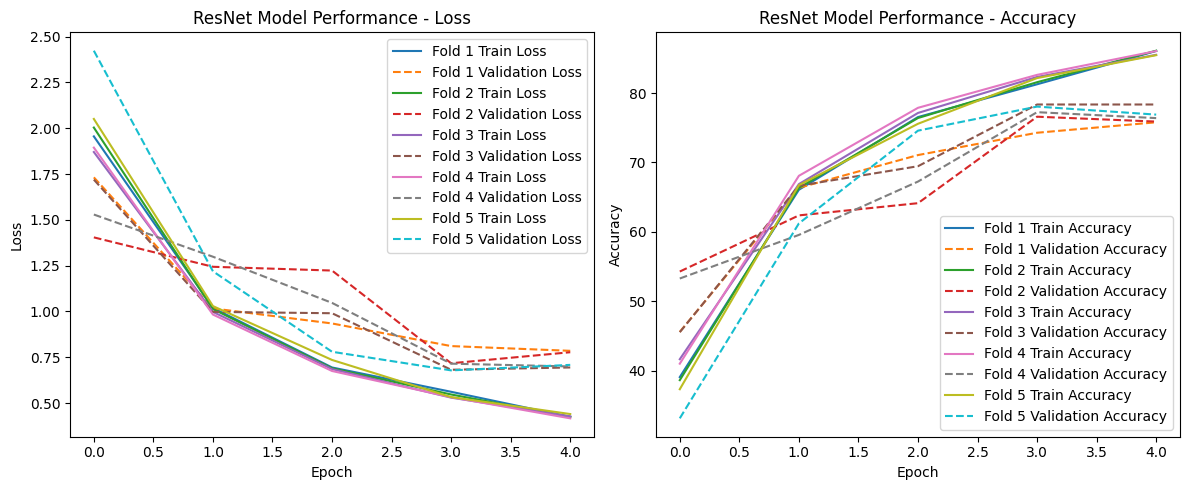


Cross-validation completed.


In [54]:
# Function to plot performance (train vs validation accuracy and loss) for each fold
def plot_performance_by_fold(fold_histories, title):
    plt.figure(figsize=(12, 5))

    # Plot Loss for each fold
    plt.subplot(1, 2, 1)
    for fold_idx, fold_history in enumerate(fold_histories):
        plt.plot(fold_history['train_loss'], label=f'Fold {fold_idx + 1} Train Loss')
        plt.plot(fold_history['val_loss'], label=f'Fold {fold_idx + 1} Validation Loss', linestyle='dashed')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy for each fold
    plt.subplot(1, 2, 2)
    for fold_idx, fold_history in enumerate(fold_histories):
        plt.plot(fold_history['train_acc'], label=f'Fold {fold_idx + 1} Train Accuracy')
        plt.plot(fold_history['val_acc'], label=f'Fold {fold_idx + 1} Validation Accuracy', linestyle='dashed')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics for each fold
plot_performance_by_fold(fold_histories, "ResNet Model Performance")

print("\nCross-validation completed.")


Exception in thread QueueFeederThreadException in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
        self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
        self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in

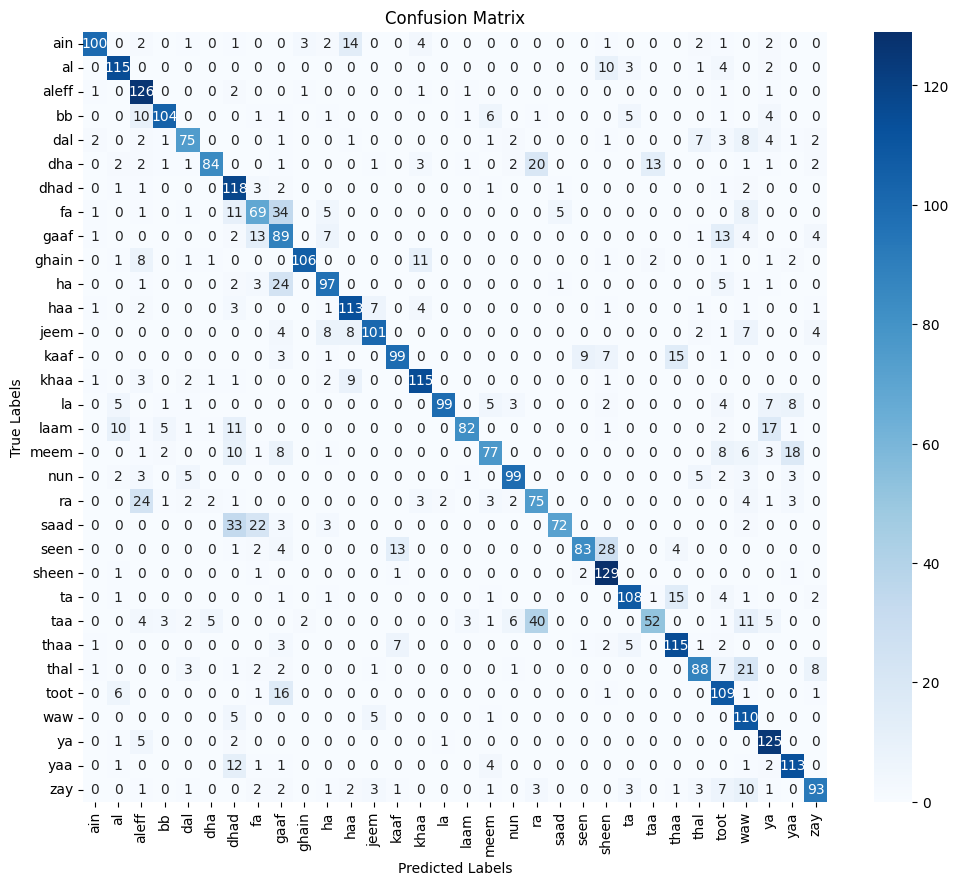


Classification Report:
              precision    recall  f1-score   support

         ain       0.92      0.75      0.83       133
          al       0.79      0.85      0.82       135
       aleff       0.64      0.94      0.76       134
          bb       0.88      0.77      0.82       135
         dal       0.78      0.68      0.72       111
         dha       0.89      0.62      0.73       135
        dhad       0.55      0.91      0.68       130
          fa       0.57      0.51      0.54       135
        gaaf       0.45      0.66      0.53       134
       ghain       0.95      0.79      0.86       135
          ha       0.75      0.72      0.73       135
         haa       0.77      0.84      0.80       135
        jeem       0.86      0.75      0.80       135
        kaaf       0.82      0.73      0.77       135
        khaa       0.82      0.85      0.83       135
          la       0.97      0.73      0.84       135
        laam       0.92      0.62      0.74       132
   

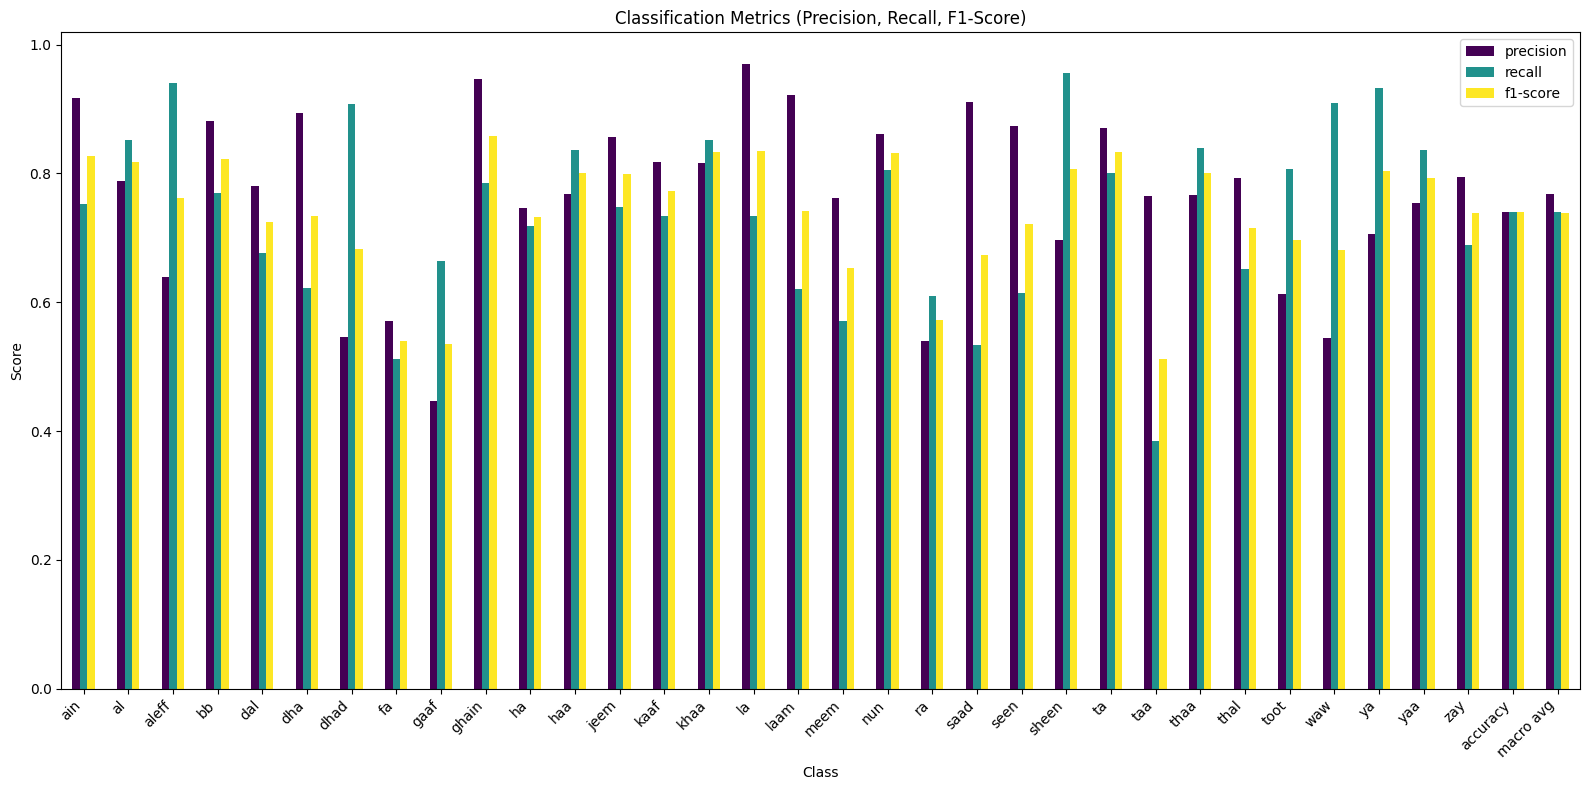

Test Accuracy: 0.74


In [69]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class_names = [
    'ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain',
    'ha', 'haa', 'jeem', 'kaaf', 'khaa', 'la', 'laam', 'meem', 'nun', 'ra',
    'saad', 'seen', 'sheen', 'ta', 'taa', 'thaa', 'thal', 'toot', 'waw', 'ya', 'yaa', 'zay'
]

# Evaluate on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Visualize precision, recall, and F1-score
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy' row
metrics_df.plot(kind='bar', figsize=(16, 8), colormap='viridis')
plt.title("Classification Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print overall accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.2f}")


Fold 1/5
Epoch [1/15], Train Accuracy: 3.09%, Train Loss: 3.7950, Validation Accuracy: 3.01%, Validation Loss: 3.4659
Epoch [2/15], Train Accuracy: 3.24%, Train Loss: 3.4654, Validation Accuracy: 3.01%, Validation Loss: 3.4647
Epoch [3/15], Train Accuracy: 5.04%, Train Loss: 3.4506, Validation Accuracy: 6.33%, Validation Loss: 3.4381
Epoch [4/15], Train Accuracy: 11.11%, Train Loss: 3.2952, Validation Accuracy: 10.95%, Validation Loss: 3.2984
Epoch [5/15], Train Accuracy: 23.78%, Train Loss: 2.8594, Validation Accuracy: 17.18%, Validation Loss: 3.1152
Epoch [6/15], Train Accuracy: 41.03%, Train Loss: 2.2495, Validation Accuracy: 23.46%, Validation Loss: 2.9703
Epoch [7/15], Train Accuracy: 55.88%, Train Loss: 1.6657, Validation Accuracy: 26.17%, Validation Loss: 2.9124
Epoch [8/15], Train Accuracy: 67.30%, Train Loss: 1.2307, Validation Accuracy: 31.14%, Validation Loss: 2.8298
Epoch [9/15], Train Accuracy: 75.29%, Train Loss: 0.9342, Validation Accuracy: 32.14%, Validation Loss: 2.943

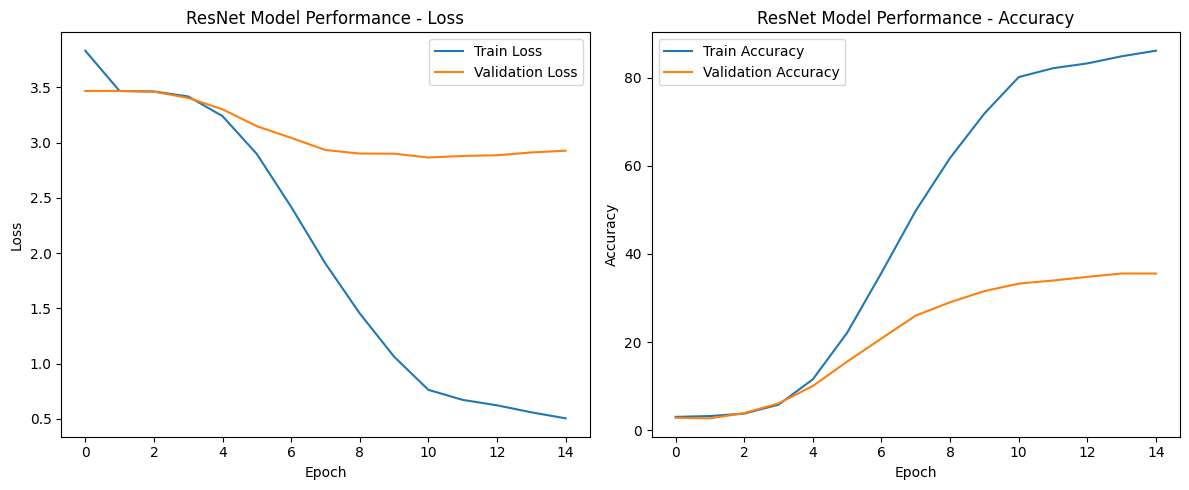


Cross-validation completed.


In [86]:
import torch.nn.functional as F  # <-- This line is needed

# History to store fold-specific metrics
fold_histories = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
    print(f"Fold {fold + 1}/{kfold.n_splits}")

    # Split data into training and validation
    train_subsampler = SubsetRandomSampler(train_idx)
    val_subsampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler, num_workers=4)
    valid_loader = DataLoader(train_dataset, batch_size=32, sampler=val_subsampler, num_workers=4)

    # Initialize model, optimizer, and scheduler
    input_size = (224, 224) 
    model = HandCraftedCNN(num_classes=32, input_size=input_size).to(device)
    optimizer, scheduler = get_optimizer_scheduler(model)

    # Metrics for the current fold
    fold_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train_fold = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train_fold += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            running_loss += loss.item()

        # Calculate training accuracy and loss for the epoch
        train_accuracy = 100 * correct_train / total_train_fold
        train_loss = running_loss / len(train_loader)
        scheduler.step()

        # Validation
        model.eval()
        correct_val = 0
        total_val_fold = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val_fold += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate validation accuracy and loss
        val_accuracy = 100 * correct_val / total_val_fold
        val_loss /= len(valid_loader)

        # Print metrics for the current epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Accuracy: {train_accuracy:.2f}%, Train Loss: {train_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}")

        # Append metrics for the current epoch to fold history
        fold_history['train_loss'].append(train_loss)
        fold_history['val_loss'].append(val_loss)
        fold_history['train_acc'].append(train_accuracy)
        fold_history['val_acc'].append(val_accuracy)

    # Save fold-specific history
    fold_histories.append(fold_history)

  

# Aggregate metrics across folds
def aggregate_folds(fold_histories):
    num_folds = len(fold_histories)
    num_epochs = len(fold_histories[0]['train_loss'])
    aggregated_history = {
        "train_loss": np.mean([fold['train_loss'] for fold in fold_histories], axis=0),
        "val_loss": np.mean([fold['val_loss'] for fold in fold_histories], axis=0),
        "train_acc": np.mean([fold['train_acc'] for fold in fold_histories], axis=0),
        "val_acc": np.mean([fold['val_acc'] for fold in fold_histories], axis=0)
    }
    return aggregated_history

aggregated_history = aggregate_folds(fold_histories)

# Plot performance
def plot_performance(history, title):
    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_performance(aggregated_history, "ResNet Model Performance")

print("\nCross-validation completed.")


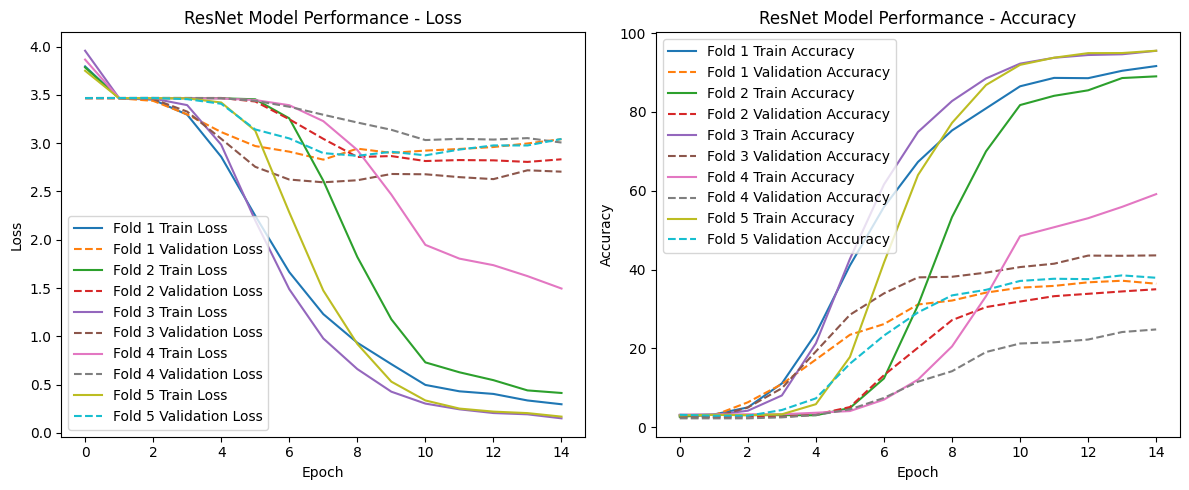


Cross-validation completed.


In [87]:
# Function to plot performance (train vs validation accuracy and loss) for each fold
def plot_performance_by_fold(fold_histories, title):
    plt.figure(figsize=(12, 5))

    # Plot Loss for each fold
    plt.subplot(1, 2, 1)
    for fold_idx, fold_history in enumerate(fold_histories):
        plt.plot(fold_history['train_loss'], label=f'Fold {fold_idx + 1} Train Loss')
        plt.plot(fold_history['val_loss'], label=f'Fold {fold_idx + 1} Validation Loss', linestyle='dashed')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy for each fold
    plt.subplot(1, 2, 2)
    for fold_idx, fold_history in enumerate(fold_histories):
        plt.plot(fold_history['train_acc'], label=f'Fold {fold_idx + 1} Train Accuracy')
        plt.plot(fold_history['val_acc'], label=f'Fold {fold_idx + 1} Validation Accuracy', linestyle='dashed')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot metrics for each fold
plot_performance_by_fold(fold_histories, "ResNet Model Performance")

print("\nCross-validation completed.")


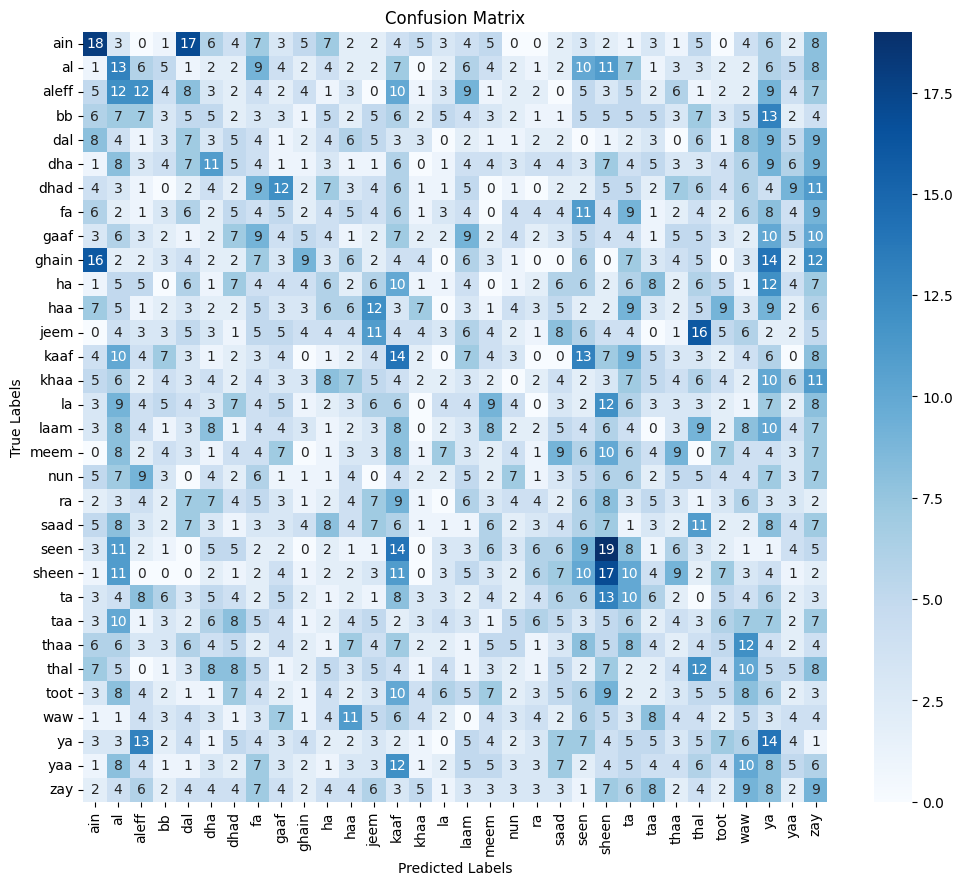


Classification Report:
              precision    recall  f1-score   support

         ain       0.13      0.14      0.13       133
          al       0.06      0.10      0.08       135
       aleff       0.10      0.09      0.09       134
          bb       0.04      0.02      0.03       135
         dal       0.05      0.06      0.06       111
         dha       0.09      0.08      0.09       135
        dhad       0.02      0.02      0.02       130
          fa       0.03      0.03      0.03       135
        gaaf       0.03      0.03      0.03       134
       ghain       0.12      0.07      0.09       135
          ha       0.05      0.04      0.05       135
         haa       0.05      0.04      0.05       135
        jeem       0.08      0.08      0.08       135
        kaaf       0.07      0.10      0.08       135
        khaa       0.03      0.01      0.02       135
          la       0.06      0.03      0.04       135
        laam       0.02      0.02      0.02       132
   

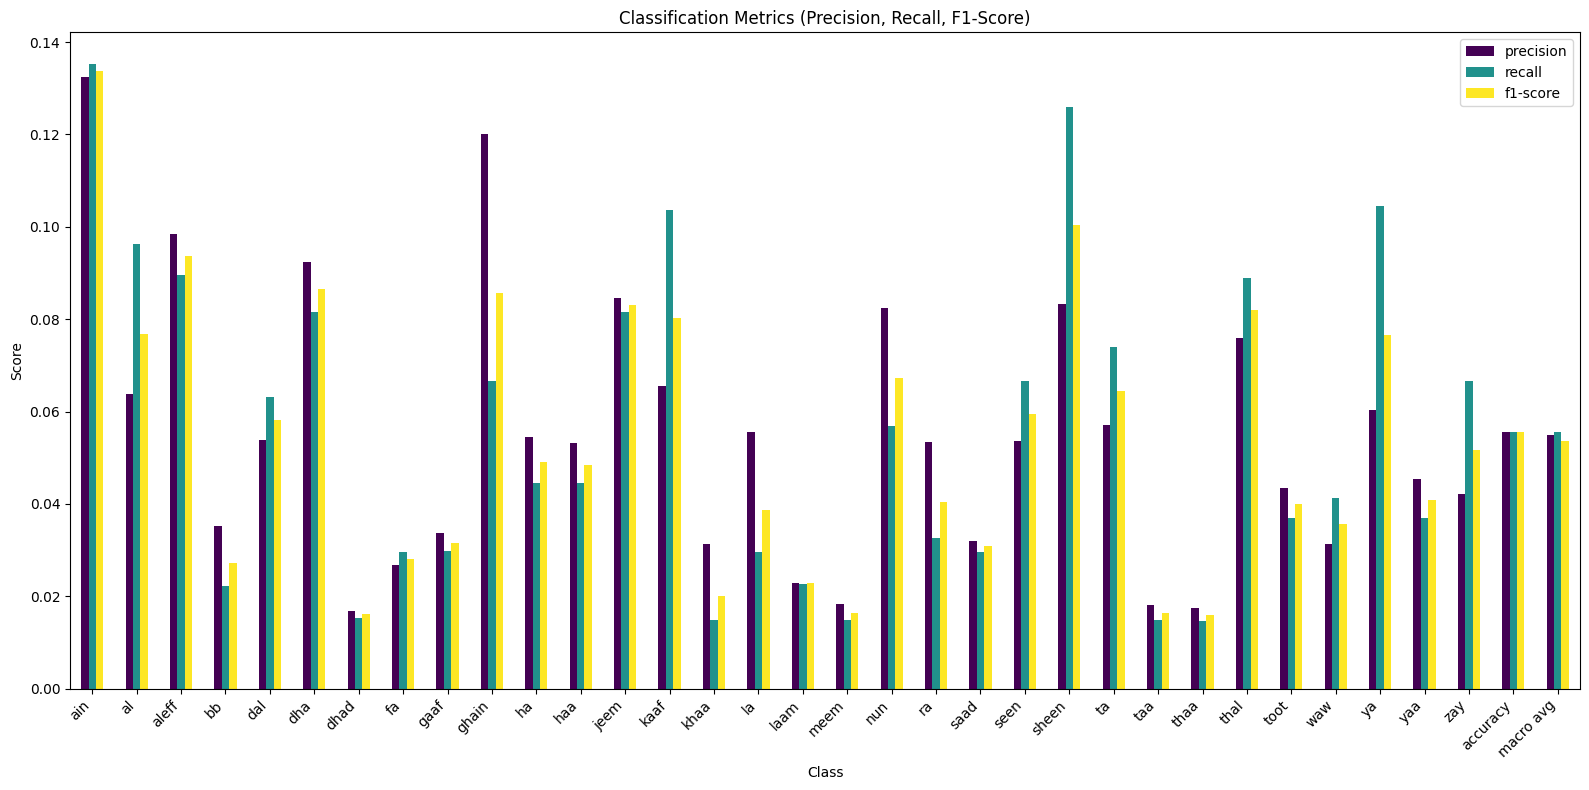

Test Accuracy: 0.06


In [88]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

class_names = [
    'ain', 'al', 'aleff', 'bb', 'dal', 'dha', 'dhad', 'fa', 'gaaf', 'ghain',
    'ha', 'haa', 'jeem', 'kaaf', 'khaa', 'la', 'laam', 'meem', 'nun', 'ra',
    'saad', 'seen', 'sheen', 'ta', 'taa', 'thaa', 'thal', 'toot', 'waw', 'ya', 'yaa', 'zay'
]

# Evaluate on test data
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report
print("\nClassification Report:")
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
print(classification_report(all_labels, all_preds, target_names=class_names))

# Visualize precision, recall, and F1-score
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy' row
metrics_df.plot(kind='bar', figsize=(16, 8), colormap='viridis')
plt.title("Classification Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xlabel("Class")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print overall accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy:.2f}")
